## Project 4: Personal Project 1 - Industrial Defect Segmentation with Unet

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imsave, imread

import os
import cv2

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

#### Basic configuration of dataset

In [5]:
image_path = 'data/'
image_height = 128
image_width = 128
image_shape = (image_height, image_width, 1)

### Step 1: Create training dataset & preprocess it

In [18]:
def create_train_data():
    
    train_data_path = os.path.join(image_path, 'train')
    data = os.listdir(train_data_path)
    data_size = int(len(data) / 2)

    idatas = np.ndarray((data_size, image_height, image_width), dtype=np.uint8)
    ldatas = np.ndarray((data_size, image_height, image_width), dtype=np.uint8)
    
    i = 0

    # Read files and separate them into idata(image_dataset) and ldata(label_dataset).
    for image_name in data:
        
        if 'label' in image_name:
            continue
        label_name = image_name.split('.')[0] + '_label.' + image_name.split('.')[1]
        idata = imread(os.path.join(train_data_path, image_name), as_grey=True)
        ldata = imread(os.path.join(train_data_path, label_name), as_grey=True)
        idata = cv2.resize(idata, (image_width, image_height), interpolation = cv2.INTER_LINEAR)
        ldata = cv2.resize(ldata, (image_width, image_height), interpolation = cv2.INTER_LINEAR)
        idatas[i] = np.array([idata])
        ldatas[i] = np.array([ldata])
        i = i + 1

#     # Save to .npy file if needed
#     np.save('train.npy', imgs)
#     np.save('train_label.npy', imgs_labels)
    
    return idatas, ldatas

In [19]:
x_train, x_label_train = create_train_data()

x_train = x_train.reshape(x_train.shape[0], image_height, image_width, 1)
x_label_train = x_label_train.reshape(x_label_train.shape[0], image_height, image_width, 1)

x_train = x_train.astype('float32')
x_label_train = x_label_train.astype('float32')
x_train = x_train / 255.0 # Normalize image dataset
x_label_train = x_label_train / 255.0 # Normalize label dataset

print(x_train.shape)
print(x_label_train.shape)

(150, 128, 128, 1)
(150, 128, 128, 1)


### Step 2: Let's take a look at one example

In [20]:
def show_img(img):
    image = img.reshape([128,128])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=2, wspace=2)
    plt.imshow(image, cmap='gray')
    plt.show()

Image with defect


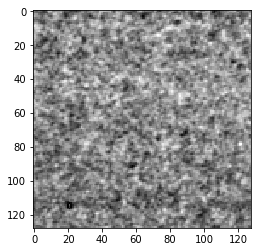

Defect labeling


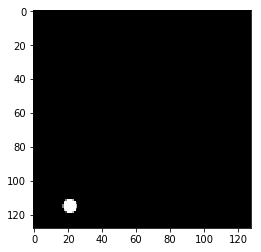

In [21]:
print('Image with defect')
show_img(x_train[10])
print('Defect labeling')
show_img(x_label_train[10])

### Step 3: Setup the model

In [22]:
inputs = Input(image_shape)

conv1 = Conv2D(32, (3, 3), activation='tanh', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='tanh', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='tanh', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='tanh', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='tanh', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='tanh', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

up4 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3), conv2], axis=3)
conv4 = Conv2D(64, (3, 3), activation='tanh', padding='same')(up4)
conv4 = Conv2D(64, (3, 3), activation='tanh', padding='same')(conv4)

up5 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4), conv1], axis=3)
conv5 = Conv2D(32, (3, 3), activation='tanh', padding='same')(up5)
conv5 = Conv2D(32, (3, 3), activation='tanh', padding='same')(conv5)

conv6 = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

model = Model(inputs=[inputs], outputs=[conv6])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

### Step 4: Define loss function & train the model

In [23]:
smooth = 1

# Measure the similarity between the ground truth (gt) and the prediction (pred).
def dice_coef(gt, pred):
    gt_f = K.flatten(gt)
    pred_f = K.flatten(pred)
    intersection = K.sum(gt_f * pred_f)
    return (2. * intersection + smooth) / (K.sum(gt_f) + K.sum(pred_f) + smooth)

# Negative of dice_coef as training tries to minimize the loss function
def dice_coef_loss(gt, pred):
    return -dice_coef(gt, pred)

In [24]:
batch_size = 64
epochs = 100

model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
model.fit(x_train, x_label_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_split=0.2)
model.save('model.h5')

Train on 120 samples, validate on 30 samples
Epoch 1/100
120/120 [==============================] - 1s 10ms/step - loss: -0.0076 - dice_coef: 0.0076 - val_loss: -0.0088 - val_dice_coef: 0.0088
Epoch 2/100
120/120 [==============================] - 0s 3ms/step - loss: -0.0101 - dice_coef: 0.0101 - val_loss: -0.0124 - val_dice_coef: 0.0124
Epoch 3/100
120/120 [==============================] - 0s 3ms/step - loss: -0.0163 - dice_coef: 0.0163 - val_loss: -0.0274 - val_dice_coef: 0.0274
Epoch 4/100
120/120 [==============================] - 0s 3ms/step - loss: -0.0426 - dice_coef: 0.0426 - val_loss: -0.0748 - val_dice_coef: 0.0748
Epoch 5/100
120/120 [==============================] - 0s 3ms/step - loss: -0.0859 - dice_coef: 0.0859 - val_loss: -0.1438 - val_dice_coef: 0.1438
Epoch 6/100
120/120 [==============================] - 0s 3ms/step - loss: -0.1732 - dice_coef: 0.1732 - val_loss: -0.0922 - val_dice_coef: 0.0922
Epoch 7/100
120/120 [==============================] - 0s 3ms/step - los

### Step 5: Create testing data & preprocess it

In [25]:
def create_test_data():
    
    test_data_path = os.path.join(image_path, 'test')
    data = os.listdir(test_data_path)
    data_size = len(data)

    tdatas = np.ndarray((data_size, image_height, image_width), dtype=np.uint8)
    
    i = 0
    
    # Read files and save into test dataset
    for image_name in data:
        
        tdata = imread(os.path.join(test_data_path, image_name), as_grey=True)
        tdata = cv2.resize(tdata, (image_width, image_height), interpolation = cv2.INTER_LINEAR)
        tdatas[i] = np.array([tdata])       
        i = i + 1

    # Save to .npy file if needed
#     np.save('test.npy', imgs)
#     np.save('test_id.npy', imgs_id)

    return tdatas

In [26]:
x_test = create_test_data()

x_test = x_test.reshape(x_test.shape[0], image_height, image_width, 1)

x_test = x_test.astype('float32')
x_test = x_test / 255.0

print(x_test.shape)

(150, 128, 128, 1)


### Step 6: Let's make some predictions

150/150 [==============================] - 0s 1ms/step


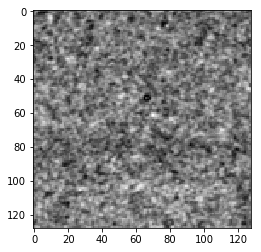

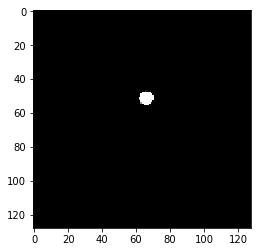

In [27]:
x_label_test = model.predict(x_test, verbose=1)

show_img(x_test[66])
show_img(x_label_test[66])